This tutorial guides you on how to train a `Transformer` model to translate from Portuguese to English.

The core idea behind the `Transformer` mechanism is the `self-attention` - the ability to address different positions of the input sequence to compute a representation of that sequence. `Transformer` creates stacks of self-attention layers and is implemented as scaled dot product attention and multi-head attention. **More specifically, a Transformer model handles variable-sized input using stacks of self-attention instead of RNNs or CNNs**.

There are several advantages to the Transformer model.
* It makes no assumptions about the temporal/spatial relationships across the data. (Idea for the set of objects)
* Layer outputs can be calculated in parallel, instead of a series, or dependent compute, like RNNs.
* Items with impacts can affect other's outputs without passing through multi-step RNN steps or CNN steps ([Scene Memory Transformer](https://arxiv.org/pdf/1903.03878.pdf)).
* It can learn long-term relationships or dependencies, this provides a solution for many sequence tasks.

The downsides of the Transformer model.
* For a time or sequence data, the output at each time step is required to calculate from the entire history instead of the inputs and the hidden states only.
* If the input has the temporal/spatial relationship, like time or text, some positional encoding must be added or the model will more effectively see a bag of words.

![](https://www.tensorflow.org/images/tutorials/transformer/attention_map_portuguese.png)

Refer to Tensorflow.org (2020) 

The following notebook shows how to build a Transformer unit from scratch. You can also use the latest API like `tf.keras.layers.MultiHeadAttention` for building Transformer.

In [1]:
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 5.1 MB/s 
     |████████████████████████████████| 462 kB 48.3 MB/s 


In [2]:
import logging
logging.basicConfig(level=logging.ERROR, 
                    format="%(asctime)s - %(levelname)s : %(message)s")

import os
import time
import matplotlib.pyplot as plt
import numpy as np

import tensorflow_text as text
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import tensorflow as tf
log = logging.getLogger('tensorflow')
log.setLevel(logging.ERROR)
print("Tensorflow Version: {}".format(tf.__version__))
print("GPU {} available.".format("is" if tf.config.experimental.list_physical_devices("GPU") else "not"))

Tensorflow Version: 2.8.0
GPU not available.


In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# Setup Input Pipeline

Here we load the [Portuguese-English translation dataset](https://github.com/neulab/word-embeddings-for-nmt) from the [TED Talks Open Translation Project](https://www.ted.com/participate/translate). This dataset contains 50000 training examples, 2000 test examples, and 1100 validation examples.

In [ ]:
examples, metadata = tfds.load("ted_hrlr_translate/pt_to_en", with_info=True, as_supervised=True)
examples, metadata

Show how many sequences in the dataset.

In [ ]:
"Train: {}, Test: {}, Validation: {}".format(
  metadata.splits['train'].num_examples, 
  metadata.splits['test'].num_examples, 
  metadata.splits['validation'].num_examples
)

Get the training and validating datasets.

In [ ]:
train_examples, val_examples = examples["train"], examples["validation"]

In [ ]:
for pt, en in train_examples.take(1):
  print("EN: {}".format(en.numpy().decode('utf-8')))
  print("PT: {}".format(pt.numpy().decode('utf-8')))

We first create tokens from the text or the sequence. Two ways of creating tokens, one is to split it by the space, and the second is to break down the words into subwords.

## Text tokenization & detokenization

Before sending the text into the model, you should tokenize the text to get the token ID list. The token ID is also the indices of the embedding.

### Word-based tokenization

In [ ]:
tokens_en = tf.keras.preprocessing.text.Tokenizer(filters='')
tokens_en.fit_on_texts([en_data.numpy().decode("utf-8") for _, en_data in train_examples])
len(tokens_en.word_index), [tokens_en.index_word[idx] for idx in range(1,11)]

In [ ]:
en_data = [en_data.numpy().decode('utf-8') for _, en_data in train_examples.take(1)]
en_data_seq_list = tokens_en.texts_to_sequences(en_data)
print(en_data_seq_list)

In [ ]:
en_data_text = tokens_en.sequences_to_texts(en_data_seq_list)
en_data_text

### Subword-based tokenization

Create a custom subwords tokenizer from the training dataset using the `tfds` APIs.

In [9]:
bert_tokenizer_params=dict(lower_case=True)
reserved_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]

bert_vocab_args = dict(
    # The target vocabulary size
    vocab_size = 9000,
    # Reserved tokens that must be included in the vocabulary
    reserved_tokens=reserved_tokens,
    # Arguments for `text.BertTokenizer`
    bert_tokenizer_params=bert_tokenizer_params,
    # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
    learn_params={},
)

In [ ]:
def write_vocab_file(file_path, vocab):
  """Write down the vocabulary file."""
  with open(file_path, "w") as fout:
    for token in vocab:
      print(token, file=fout)

if not os.path.exists("pt.txt"):
  pt_vocab = bert_vocab.bert_vocab_from_dataset(
      train_examples.map(lambda pt, en: pt).prefetch(10),
      **bert_vocab_args
  )
  write_vocab_file("pt.txt", pt_vocab)
if not os.path.exists("en.txt"):
  en_vocab = bert_vocab.bert_vocab_from_dataset(
      train_examples.map(lambda pt, en: en).prefetch(10),
      **bert_vocab_args
  )
  write_vocab_file("en.txt", en_vocab)

In [11]:
if os.path.exists("pt.txt"):
  pt_vocab = open("pt.txt").read().split('\n')
  print("Number of subword-based tokens for PT: {}".format(len(pt_vocab)))
  print(pt_vocab[100:120])

if os.path.exists("en.txt"):
  en_vocab = open("en.txt").read().split('\n')
  print("Number of subword-based tokens for EN: {}".format(len(en_vocab)))
  print(en_vocab[100:120])

In [ ]:
assert os.path.exists("pt.txt")
tokenizer_pt = text.BertTokenizer("pt.txt", **bert_tokenizer_params)

assert os.path.exists("en.txt")
tokenizer_en = text.BertTokenizer("en.txt", **bert_tokenizer_params)

In [ ]:
sample_string = "Transformer is nice."

tokenized_string = tokenizer_en.tokenize(sample_string)
print("Tokenized String: {}".format(tokenized_string))

decoded_string = tokenizer_en.detokenize(tokenized_string)
print("Detokenized IDs: {}".format(decoded_string))
decoded_string = decoded_string.merge_dims(outer_axis=-2, inner_axis=-1)
print("Merge: {}".format(decoded_string))
print("String: {}".format(
  ' '.join([v.decode('utf-8') for v in tf.squeeze(decoded_string, axis=0).numpy()])
))

print("1761 -> {}".format(tokenizer_en.detokenize([[1761]])))
print("227 -> {}".format(tokenizer_en.detokenize([[227]])))

Add a start and end token to the input and the target.

In [ ]:
START = tf.argmax(tf.constant(reserved_tokens) == "[START]")
END = tf.argmax(tf.constant(reserved_tokens) == "[END]")

def add_start_end(ragged):
  """Add the [START] in the front of the string and [END] in the end of string."""
  count = ragged.bounding_shape()[0]
  starts = tf.fill([count, 1], START)
  ends = tf.fill([count, 1], END)
  return tf.concat([starts, ragged, ends], axis=1)

def encode(lang1, lang2):
  """Encode both of lang1 and lang2 into the indices."""
  lang1 = add_start_end(tokenizer_pt.tokenize(lang1).merge_dims(-2, -1))
  lang2 = add_start_end(tokenizer_en.tokenize(lang2).merge_dims(-2, -1))
  return lang1, lang2

In [ ]:
for pt, en in train_examples.take(1):
  pt_, en_ = encode(pt, en)
  print("PT: {}".format(pt_))
  print("detokenized PT: {}".format(tokenizer_pt.detokenize(pt_)))
  print()
  print("EN: {}".format(en_))
  print("detokenized EN: {}".format(tokenizer_en.detokenize(en_)))

## Dataset Pipeline

To keep the dataset small and training fast, drop examples with a length of over 40 tokens. 

In [ ]:
MAX_LENGTH = 40

In [ ]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
  """That only both of x and y are less than MAX_LENGTH is allowed being datasets."""
  return tf.logical_and(tf.size(x) <= max_length, tf.size(y) <= max_length)

x = tf.constant(tf.range(30))
y = tf.constant(tf.range(90))
filter_max_length(x, y).numpy()

Build the input pipeline.

In [ ]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

def tokenize_pairs(pt, en):
  """Convert from ragged to dense, padding with zeros."""
  pt = tf.squeeze(pt.to_tensor(), axis=1)
  en = tf.squeeze(en.to_tensor(), axis=1)
  return pt, en

train_dataset = train_examples.map(encode)\
  .filter(filter_max_length)\
  .cache()\
  .shuffle(BUFFER_SIZE)\
  .batch(BATCH_SIZE)\
  .map(tokenize_pairs)\
  .prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = val_examples.map(encode)\
  .filter(filter_max_length)\
  .batch(BATCH_SIZE)

In [ ]:
pt_batch, en_batch = next(iter(train_dataset))
pt_batch[0], en_batch[0]

# Positional Encoding

The transformer model does not contain any recurrent or convolution unit, it requires the `positional encoding` to give the model additional information about the relative position of words in the sentence.

**The basic idea of the positional encoding is to add it to the embedding vector**. Embeddings represent a token (words or subwords) in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embedding doesn't contain the relative position of words in a sentence. After adding the position encoding vector, tokens will be closer to the similar one based on their meanings and their positions in the sentence, in its d-dimensional space.

More details about the [positional encoding](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb).

The formula for calculating the positional encoding.

$$PE_{(pos,2i)} = sin(pos/10000^{2i/d_{model}})$$
$$PE_{(pos,2i+1)} = cos(pos/10000^{2i/d_{model}})$$

In [ ]:
def get_angles(pos, i, d_model):
  """Calculate the angles."""
  angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
  return pos * angle_rates  # (pos, d_model)

Use the number of dimensions (d_model) to represent each position that is summed equal to the value of pos.

In [ ]:
def positional_encoding(position, d_model):
  """
  Args:
    position: the number of positions in shape (p,)
    d_model: the dimension of the model in shape (d,)
  
  Returns:
    (1, position, d_position)
  """
  # to assemble the new matrix in shape (position, d_model)
  angle_rads = get_angles(np.arange(position)[:, np.newaxis], 
                          np.arange(d_model)[np.newaxis, :], 
                          d_model)
  
  # apply sin to even indices in the array (2i)
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array (2i+1)
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  angle_rads = tf.expand_dims(angle_rads, axis=0)

  return tf.cast(angle_rads, tf.float32)

In [ ]:
pos_encoding = positional_encoding(100, 512)
print(pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap="RdBu")
plt.title("Positional Encoding")
plt.xlabel("Depth (Dimension)")
plt.xlim([0, 512])
plt.ylabel("Position")
plt.colorbar()
plt.show()

# Masking

## Padded Mask

Mask all pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where `pad` value 0 is present, it outputs a `1` at those locations, and a `0` otherwise. 

In [ ]:
def create_padding_mask(seq):
  """
  Args:
    seq: (batch_size, sequence_length)

  Returns: (batc_size, 1, 1, sequence_length)
  """
  seq_ = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding information
  return seq_[:, tf.newaxis, tf.newaxis, :]

In [ ]:
x = tf.constant([[2, 7, 7, 3, 0, 0, 0], [2, 10, 20, 30, 3, 0, 0]])
x.numpy(), create_padding_mask(x).numpy()

## Look-ahead Mask

The `look-ahead` mask is used to mask the future tokens in a sequence. For example, to predict the third token only the first and the second token will be used.

In [ ]:
def create_look_ahead_mask(size):
  """Create the look ahead mask."""
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask # (seq_len, seq_len)

In [ ]:
x = tf.random.uniform((1, 5))
create_look_ahead_mask(x.shape[1])

# Scaled Dot Product Attention

![](https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png)

Refer to Tensorflow.org (2020).

The attention function used by a transformer takes three inputs, Q (Query), K (Key), and V (Value). The formula to calculate the attention weights is:

$$Attention(Q,K,V)=softmax_K(\frac{QK^T}{\sqrt{d_K}})V$$

- The query in the additive attention is the deocder input.
- The key and value in the additive attention are the encoder output and state. 

The dot-product attention is scaled by a factor of square root of the depth. This is quite smart if for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting on a hard softmax. 

Consider that Q and K have a mean of 0 and variance of 1. The matrix multiplication will have a mean of 0 and variance of dk, so that the square root of dk is used for scaling.

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculated the attention weights.
  q, k, v: have the same leading dimensions
  q, k: have the same last dimensions
  k, v: have the same penultimate dimension, for example, seq_len_k == seq_len_v
  mask: has different shapes depending on its type (padding or look head)

  Args:
    q (query): shape (..., seq_len_q, depth)
    k (key): shape (..., seq_len_k == encoder_timestamp, depth)
    v (value): shape (..., seq_len_v == encoder_timestamp, depth_v)
    mask: default is None,
          or Float tensor with shape broadcastable to (..., seq_len_q, seq_len_k)

  Returns:
    output, attention_weight
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  # -1e-9, not 0 for softmax

  # softmax is on the last axis (seq_len_k) so that the scores add up to 1
  attention_weight = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weight, v)  #(..., seq_len_q, seq_len_v)
  return output, attention_weight

After the softmax normalization is done on K, its value represents the amount of importance given to Q. In the end, the matrix multiplication represents the words you want to focus on are kept as-is and the irrelevant ones are flushed out.

In [ ]:
def print_output_shape(q, k, v):
  """Check the output shape from the scaled dot product attention."""
  temp_out, temp_weights = scaled_dot_product_attention(q, k, v, None)
  print("Output:", temp_out)
  print("Attention Weights:", temp_weights)

In [ ]:
np.set_printoptions(suppress=True)

temp_K = tf.constant([[10, 0, 0, 0], 
                      [0, 10, 0, 0], 
                      [0, 0, 10, 0], 
                      [0, 0, 0, 10]], dtype=tf.float32)  # (1, 4, 4)

temp_V = tf.constant([[10, 1], 
                      [100, 10], 
                      [1000, 100], 
                      [10000, 1000]], dtype=tf.float32)  # (1, 4, 2)

temp_Q = tf.constant([[0, 0, 1, 0], 
                      [0, 1, 0, 0]], dtype=tf.float32)  # (1, 2, 4)

print_output_shape(temp_Q, temp_K, temp_V)

**After the above validation, you will find out the attention weights are the relations between the query and keys. That is, the relations between the outputs (decoder) and inputs (encoder).** Let's calculate step by step.

In [ ]:
temp_QK = tf.matmul(temp_Q, temp_K, transpose_b=True)  # (1, 2, 4)
print(temp_QK.shape, temp_QK)

scaled_QK = temp_QK / tf.math.sqrt(tf.cast(tf.shape(temp_K)[-1], tf.float32))  # (1, 2, 4)
print(scaled_QK)

softmax_QK = tf.nn.softmax(scaled_QK, axis=-1)  # (1, 2, 4)
print(softmax_QK)

tf.matmul(softmax_QK.numpy(), temp_V)

# Multi-Head Attention

![](https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png)

Tensorflow.org (2020)

Each attention block gets three inputs: V(Value), K(Key), and Q(Query). These are put through the linear layer before the scaled dot-product attention.

In the following, we use a simplied dense layer for those inputs with `num_heads` to represent the number of many heads (`h` in the diagram). In the following, we also split the dimension with heads for simplicity. The output shape would be `[batch, num_heads, ...]` before applying the attention function.

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()

    assert d_model % num_heads == 0

    self.d_model = d_model
    self.num_heads = num_heads
    self.d_depth = d_model // num_heads

    self.wq = tf.keras.layers.Dense(units=d_model)
    self.wk = tf.keras.layers.Dense(units=d_model)
    self.wv = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_head(self, x, batch_size):
    x = tf.reshape(x, shape=(batch_size, -1, self.num_heads, self.d_depth))

    # change to (batch_size, num_heads, seq_len, d_depth)
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    return x

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len_q, d_model)
    k = self.wk(k)  # (batch_size, seq_len_k, d_model)
    v = self.wv(v)  # (batch_size, seq_len_v, d_model)

    q = self.split_head(q, batch_size)  # (batch_size, num_heads, seq_len_q, d_depth)
    k = self.split_head(k, batch_size)  # (batch_size, num_heads, seq_len_k, d_depth)
    v = self.split_head(v, batch_size)  # (batch_size, num_heads, seq_len_v, d_depth)

    # output: (batch_size, num_heads, seq_len_q, seq_len_v == d_depth)
    #         seq_len_v == d_depth is from self.qv()
    # attention: (batch_size, num_heads, seq_len_q, seq_len_k)
    output, attention = scaled_dot_product_attention(q=q, k=k, v=v, mask=mask)

    # concatenation
    scaled_output = tf.transpose(output, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, d_depth)
    concat_output = tf.reshape(scaled_output, shape=(batch_size, -1, self.d_model))

    output = self.dense(concat_output)  # (batch_size, seq_len_q, d_model)
    return output, attention

Create a `MultiHeadAttention` layer to try out.

In [ ]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
x = tf.random.uniform(shape=(10, 50, 256))  # (batch_size, seq_length, embedding + positional)
temp_outputs, temp_attentions = temp_mha(v=x, k=x, q=x, mask=None)

# temp_outputs: (batch_size=10, seq_len=50, d_model=512)
# temp_attentions: (batch_size=10, num_heads=8, seq_len_q=50, seq_len_k=50)
temp_outputs.shape, temp_attentions.shape

# Point Wise Feed Forward Network

The feed forward network is used after the multi-head attention for summarizing. The encoder's FNN is also the hidden state for the decoder.

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
    tf.keras.layers.Dense(units=dff, activation='relu'),
    tf.keras.layers.Dense(units=d_model)
  ])

In [ ]:
point_wise = point_wise_feed_forward_network(d_model=512, dff=2048)
point_wise(tf.random.uniform(shape=(32, 64, 256))).shape   # (32, 64, 256) -> (32, 64, 512)

# Encoder and Decoder

![](https://www.tensorflow.org/images/tutorials/transformer/transformer.png)

Tensorflow.org (2020)

The transformer model also adopts the encoder-decoder architecture. 
- The input squence is passed through N encoder layers that generates an output for each token in the sequence.
- The decoder attends encoder's output and its own inputs (self-attention) to predict the next word.

## Encoder Layer

An encoder consists of two sublayers.
* A multi-head attention (with padded mask).
* A point-wise feed-forward network.

Each of these encoder layer consists of the residual connections for avoid gradient vanishing. Each of sublayers above is passed through the `LayerNormalization`. The normalization is done on `d_model` axis.

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  """Implement the encoder layer."""

  def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
    self.ffn = point_wise_feed_forward_network(d_model=d_model, dff=dff)

    self.dropout1 = tf.keras.layers.Dropout(rate=dropout_rate)
    self.dropout2 = tf.keras.layers.Dropout(rate=dropout_rate)    

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

  def call(self, x, training, mask):
    """
    x: (batch_size, seq_len_q, d_model) over positional encoding
    """
    
    # mha_output:     e.g. (batch_size=10, seq_len=50, d_model=512)
    # mha_attentions: e.g. (batch_size=10, num_heads=8, seq_len_q=50, seq_len_k=50)

    mha_output, _ = self.mha(v=x, k=x, q=x, mask=mask) 
    dropout_output1 = self.dropout1(mha_output, training=training)
    output1 = self.layernorm1(x + dropout_output1) # (batch_size, seq_len_q, d_model)

    ffn_output = self.ffn(output1)
    dropout_output2 = self.dropout2(ffn_output, training=training)
    output2 = self.layernorm2(output1 + dropout_output2)  # (batch_size, seq_len_q, d_model)
    
    return output2

Let's build a encoder layer with an example first.

In [ ]:
temp_encoder_layer = EncoderLayer(512, 8, 2048, 0.1)
temp_encoder_layer_output = temp_encoder_layer(
  tf.random.normal(shape=(32, 36, 512)), training=False, mask=None  # (batch_size=32, seq_len_q=36, d_model=512)
)
temp_encoder_layer_output.shape

## Decoder Layer

A decoder layer consists of three sublayers.
* A masked multi-head attention layer (with a padded mask and a look ahead mask).
* A multi-head attention layer (with a padded mask).
* A point-wise feed-forward network.

The second multi-head attention layer receives the output and value from the encoder as the key (K) and value (V). It also receives the query (Q) from the the first multi-head attention layer. This attention layer does the prediction by watching the output from the encoder and the current input from decoder.

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  """Implement the deocder layer."""
  
  def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
    self.dropout1 = tf.keras.layers.Dropout(rate=dropout_rate)
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.mha2 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
    self.dropout2 = tf.keras.layers.Dropout(rate=dropout_rate)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.ffn = point_wise_feed_forward_network(d_model=d_model, dff=dff)
    self.dropout3 = tf.keras.layers.Dropout(rate=dropout_rate)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

  def call(self, x, encoder_output, training, look_ahead_mask, padded_mask):
    # x: (batch_size, seq_len_q, d_model)
    # encoder_output: (batch_size, seq_len_q, d_model)

    # mha1_output: (batch_size, seq_len_q, d_model)
    # mha1_attention: (batch_size, num_heads, seq_len_q, seq_len_k)
    mha1_output, mha1_attention = self.mha1(v=x, k=x, q=x, mask=look_ahead_mask)
    mha1_dropout = self.dropout1(mha1_output, training=training)
    output1 = self.layernorm1(x + mha1_dropout)  # (batch_size, seq_len_q, d_model)     

    # mha2_output: (batch_size, seq_len_q, d_model)
    # mha2_attention: (batch_size, num_heads, seq_len_q, seq_len_q)
    mha2_output, mha2_attention = self.mha2(
      v=encoder_output, k=encoder_output, q=output1, mask=padded_mask)
    mha2_dropout = self.dropout2(mha2_output, training=training)
    output2 = self.layernorm2(output1 + mha2_dropout)  # (batch_size, seq_len_q, d_model)

    ffn_output = self.ffn(output2)  # (batch_size, seq_len_q, d_model)
    ffn_dropout = self.dropout3(ffn_output, training=training)
    output3 = self.layernorm3(output2 + ffn_dropout)  # (batch_size, seq_len_q, d_model)

    return output3, mha1_attention, mha2_attention

Let's try the decoder layer.

In [ ]:
temp_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)
temp_deocder_layer_output, temp_mha1_attn, temp_mha2_attn = temp_decoder_layer(
  x = tf.random.normal(shape=(32, 36, 512)),
  encoder_output = temp_encoder_layer_output,
  training=False,
  look_ahead_mask=None,
  padded_mask=None
)

"""
temp_deocder_layer_output: (batch_size=32, seq_len_q=30, d_model=512)
temp_mha1_attn: (batch_size=32, num_heads=8, seq_len_q=30, seq_len_k=30)
temp_mha2_attn: (batch_size=32, num_heads=8, seq_len_q=30, seq_len_q=30)
"""
temp_deocder_layer_output.shape, temp_mha1_attn.shape, temp_mha2_attn.shape

**The attention weights in the decoder layer are focusing on itself (the button layer, the look-ahead mask), and focusing on the encoder output (the upper layer, the padded mask).**

## Encoder

An encoder consists of:
* Input Embedding
* Positional Encoding
* N times Encoder layers

The encoder sums an input embedding and a positional encoding as the input to the encoder. The encoder's output would be the input of the decoder.

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               max_positional_encoding, dropout_rate=0.1):
    """
    Args:
      num_layers: the number of decoder layer
      num_heads: the number of heads
      d_model: the dimension of multi-heads, fnn, embedding layer, positional encoding
      dff: the dimension in point wise feed forwaed network
      input_vocab_size: the vocab size of subwords for word embedding
      max_positional_encoding: the max number of the sequence length,
                               it can be assigned as the input_vocab_size
      dropout_rate: for the dropout layer
    """
    super(Encoder, self).__init__()

    self.embedding = tf.keras.layers.Embedding(
        input_dim=input_vocab_size, 
        output_dim=d_model)
    self.positions = positional_encoding(
        position=max_positional_encoding, 
        d_model=d_model)
    self.encoders = [
        EncoderLayer(
            d_model=d_model, 
            num_heads=num_heads, 
            dff=dff, 
            dropout_rate=dropout_rate) \
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)

    # used in the call function
    self.d_model = d_model
    self.num_layers = num_layers

  def call(self, x, training, mask):
    """
    Args:
      x: the input in shape (batch_size, seq_len)
      training: True ot False
      mask: the padded mask
    Returns:
      outputs: the input of the decoder in shape (batch_size, x_seq_len, d_model)
    """
    embedding = self.embedding(x)  # (batch_size, x_seq_len, d_model)
    
    # scaled the embedding value for adding positional encoding
    embedding *= tf.sqrt(tf.cast(self.d_model, tf.float32))

    # get the sequence length for positional encoding
    input_seq_len = tf.shape(x)[1]
    pos_embed = embedding + self.positions[:, :input_seq_len, :]

    pos_embed = self.dropout(pos_embed, training=training)
    x_ = pos_embed

    # N x EncoderLayers
    for idx in range(self.num_layers):
      x_ = self.encoders[idx](x_, training, mask)

    return x_  # (batch_size, x_seq_len, d_model)

Let's try the enconder first.

In [ ]:
simple_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, dff=2048, 
                         input_vocab_size=len(pt_vocab), 
                         max_positional_encoding=10000)

# generate the example batch input sequences
temp_input = tf.random.uniform(shape=(64, 62), dtype=tf.int64, minval=0, maxval=200)

encoder_output = simple_encoder(temp_input, training=False, mask=None)
encoder_output.shape  # (batch_size=64, seq_len=62, d_model=512)

## Decoder

In [ ]:
class Decoder(tf.keras.layers.Layer):
  """Implement the deocder."""

  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, 
               max_positional_encoding, dropout_rate=0.1):
    super(Decoder, self).__init__()

    # [batch_size, seq_len, d_model]
    self.embedding = tf.keras.layers.Embedding(
        input_dim=target_vocab_size, 
        output_dim=d_model)
    # [1, num_position, d_model]
    self.positions = positional_encoding(
        position=max_positional_encoding, 
        d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(
        rate=dropout_rate)
    self.decoders = [
        DecoderLayer(d_model=d_model, 
                     num_heads=num_heads, 
                     dff=dff, 
                     dropout_rate=dropout_rate) \
        for _ in range(num_layers)]

    # for the function call
    self.num_layers = num_layers
    self.d_model = d_model

  def call(self, x, encoder_output, training, look_ahead_mask, mask):
    """
    Args:
      x: the target, here is English, in shape (batch_size, seq_len)
      encoder_output: the encoder output in shape (batch_size, encoder_input_seq_len, d_model)
      training: True or False
      look_ahead_mask: (batch_size, seq_len, seq_len)
      mask: the padded mask in shape (batch_size, 1, 1, decoder_input_seq_len)

    Returns:
      output: the decoder output in shape (batch_szie, decoder_input_seq_len, d_model)
      attentions: a dictionary for two stage attention weights
    """
    attentions = {}   # for returns

    embed = self.embedding(x)  # (batch_size, seq_len, d_model)
    # scaled for adding positional encoding
    embed *= tf.sqrt(tf.cast(self.d_model, tf.float32))  

    # add the positional information
    input_seq_len = tf.shape(x)[1]
    pos_embed = embed + self.positions[:, :input_seq_len, :]

    x_ = self.dropout(pos_embed, training=training)

    # decoder layers
    for idx in range(self.num_layers):
      x_, attn1, attn2 = self.decoders[idx](x_, 
                                            encoder_output=encoder_output, 
                                            training=training, 
                                            look_ahead_mask=look_ahead_mask, 
                                            padded_mask=mask)
      attentions['decoder_layer{}_block1'.format(idx)] = attn1
      attentions['decoder_layer{}_block2'.format(idx)] = attn2

    return x_, attentions

Let's try the decoder.

In [ ]:
simple_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, dff=2048, 
                         target_vocab_size=len(en_vocab), 
                         max_positional_encoding=10000)

temp_decoder_input = tf.random.uniform(shape=(64, 68), minval=0, maxval=200)
outputs, attentions = simple_decoder(x=temp_decoder_input, 
                                     encoder_output=encoder_output, 
                                     training=False, 
                                     look_ahead_mask=None, 
                                     mask=None)

print(outputs.shape)  # (batch_size=64, decoder_input_seq_len=68, d_model=512)
for key, val in attentions.items():
  print("Key: {}, shape: {}".format(key, val.shape))

# Create the Transformer

The Transformer consists of:
* An encoder
* A decoder
* A final linear layer 

The overall workflow is:
* The encoder takes Portuguese sequence as the input. 
* The decoder takes the encoder's output and the English sequence as the input. After attention's layers, the decoder uses the linear and softmax to get the subword indices.

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, 
               input_vocab_size, target_vocab_size, 
               input_pos_enc, target_pos_enc, dropout_rate=0.1):
    """
    Args:
      num_layers: the number of layers stacked in the encoder and the decoder
      d_model: the dimension of representation used in the encoder and the decoder
      num_heads: how many splited heads
      dff: the dimension of point-wise feed forard network used in the encoder an the decoder
      input_vocab_size: for creating an embedding layer in the encoder
      target_vocab_size: for creating an embedding layer in the decoder
      input_pos_enc: the max position for encoding
      target_pos_enc: tha max position for decoding
      dropout_rate: the rate for the Dropout layer
    """
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers=num_layers, 
                           d_model=d_model, 
                           num_heads=num_heads, 
                           dff=dff, 
                           input_vocab_size=input_vocab_size, 
                           max_positional_encoding=input_pos_enc,
                           dropout_rate=dropout_rate)
    self.decoder = Decoder(num_layers=num_layers, 
                           d_model=d_model, 
                           num_heads=num_heads, 
                           dff=dff, 
                           target_vocab_size=target_vocab_size, 
                           max_positional_encoding=target_pos_enc,
                           dropout_rate=dropout_rate)
    # the final layer generates the subword probabilities of the target language
    self.final_layer = tf.keras.layers.Dense(units=target_vocab_size)

  def create_masks(self, inp, tar):
    """Create the masks."""
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)  
    return enc_padding_mask, look_ahead_mask, dec_padding_mask  

  def call(self, inputs, targets, training):
    """
    Args:
      inputs: the subword list created from the Portuguese text
      targets: the subword list created from the English text
      training: True or False

    Returns:
      final_output: (batch_size, target_seq_length, target_vocab_size)
      attentions: a dictionary keeps the attentions of blocks in each decoder layer
    """

    """
    enc_padding_mask: the padded mask used in the encoder
    look_ahead_mask: the look-ahead mask used in the 
                      button multi-head attenation of the decoder
    dec_padding_mask: the padded mask used in the 
                      upper multi-head attention of the decoder    
    """
    enc_padding_mask, look_ahead_mask, dec_padding_mask \
      = self.create_masks(inputs, targets)
    print(inputs)
    print(targets)

    # enc_output: (batch_size, inputs_seq_length, d_model)
    enc_output = self.encoder(inputs, training=training, mask=enc_padding_mask) 

    # dec_output: (batch_size, target_seq_length, d_model)
    dec_output, attentions = self.decoder(targets, 
                                          encoder_output=enc_output, 
                                          training=training, 
                                          look_ahead_mask=look_ahead_mask, 
                                          mask=dec_padding_mask)

    # final_output: (batch_size, target_seq_length, target_vocab_size)
    final_output = self.final_layer(dec_output)

    return final_output, attentions

Let's build a simple transformer.

In [ ]:
simple_transformer = Transformer(num_layers=2, 
                                 d_model=512, 
                                 num_heads=8, 
                                 dff=2048, 
                                 input_vocab_size=len(pt_vocab), 
                                 target_vocab_size=len(en_vocab),
                                 input_pos_enc=10000, 
                                 target_pos_enc=10000)

temp_input = tf.random.uniform(shape=(64, 70), minval=0, maxval=200, dtype=tf.int32)
temp_target = tf.random.uniform(shape=(64, 68), minval=0, maxval=200, dtype=tf.int32)

final_output, attentions = simple_transformer(
    inputs=temp_input, 
    targets=temp_target, 
    training=False)

print("The shape of the decoder: {}".format(final_output.shape))
for key, val in attentions.items():
  print("Key: {}, Val shape: {}".format(key, val.shape))

# Set the Hyperparameters

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = len(pt_vocab)
target_vocab_size = len(en_vocab)
dropout_rate = 0.1

# Customized Optimizer

Use the Adam optimizer with $\beta_1 = 0.9$, $\beta_2 = 0.98$, and $\epsilon=10^{-9}$. The learning rate scheduler follows the formula.

$$lrate = d^{-0.5}_{model} * min(step\_num^{-0.5}, step\_num * warmup\_steps^{-1.5})$$

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  """Define a customized optimizer scheduler."""
  def __init__(self, d_model, warmup_step=4000):
    self.d_model = tf.cast(d_model, tf.float32)
    self.warmup_step = warmup_step
  
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_step ** (-1.5))
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model=d_model, warmup_step=4000)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [ ]:
simple_lr = CustomSchedule(d_model=d_model)

plt.plot(simple_lr(tf.range(40000, dtype=tf.float32)))
plt.xlabel("Training Step")
plt.ylabel("Learning Rate")
plt.show()

# Loss and Metrics

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
  from_logits=True, reduction='none'
)

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))

  # real: (batch_size, seq_length)
  # pred: (batch_size, seq_length, target_vocab_size)
  loss = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask
  return tf.reduce_mean(loss)

def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [ ]:
#train_loss = tf.keras.metrics.SparseCategoricalCrossentropy(name='train_loss')
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

# Training and Checkpointing

In [ ]:
transformer = Transformer(num_layers=num_layers, 
                          d_model=d_model, 
                          num_heads=num_heads, 
                          dff=dff, 
                          input_vocab_size=len(pt_vocab), 
                          target_vocab_size=len(en_vocab),
                          input_pos_enc=10000, 
                          target_pos_enc=10000,
                          dropout_rate=dropout_rate)

Create the checkpoint and its manager to save it every `n` epochs.

In [ ]:
# saving_path = "/content/gdrive/My Drive/tmp/model_saving/"
saving_path = "./"
assert os.path.exists(saving_path)

In [ ]:
ckpt_path = os.path.join(saving_path, "ckpts", "train")

ckpt = tf.train.Checkpoint(transformer=transformer, 
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(checkpoint=ckpt, 
                                          directory=ckpt_path, 
                                          max_to_keep=5)

# restore the checkpoint if it exists
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print("Latest checkpoint restored.")

The target is divided into `target_input` and `target_real`. The `target_input` is passed as the input to the decoder. The `target_real` is the same input shifted by 1 to represent next token that should be predicted.

For example, 
* The `target` string is `SOS Transformer is awesome EOS`.
* The `target_input` string is `SOS Transformer is awesome`.
* The `target_real` string is `Transformer is awesome EOS`.

Train the transformer using `teacher-forcing`. The teacher-forcing is to pass the correct token to the next step regardless of what the output model predicts.

As the transformer predicts each word, it is allowed to look at the previous words of the input sequence to make the prediction. However, it is not allowed to peak at the expected output token using a `look-ahead mask`.


In [ ]:
train_step_signature = [
  tf.TensorSpec(shape=(None, None), dtype=tf.int64),  # input shape: (batch_size, seq_len)
  tf.TensorSpec(shape=(None, None), dtype=tf.int64),  # target shape: (batch_size, seq_len)
]

@tf.function(input_signature=train_step_signature)
def train_step(inputs, targets):
  targets_input = targets[:, :-1]
  targets_real = targets[:, 1:]
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inputs=inputs, 
                                 targets=targets_input,
                                 training=True)
    
    loss = loss_function(targets_real, predictions)

  # calculate the gradients and apply them to trainable variables
  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  # update the loss and accuracy of the batch data
  train_loss(loss)
  train_accuracy(targets_real, predictions)

Complete the training process.

In [ ]:
EPOCHS = 20
peroid = 0

for epoch in range(EPOCHS):
  peroid = time.time()

  # reset the statue
  train_loss.reset_states()
  train_accuracy.reset_states()

  # inputs: Portuguese, targets: English
  for batch, (inputs, targets) in enumerate(train_dataset):
    train_step(inputs, targets)

    if (batch + 1) % 200 == 0:
      print("Epoch {}, Batch {}, Loss {:.6f}, Accuracy {:.6f}".format(
        epoch + 1, batch, train_loss.result(), train_accuracy.result()
      ))

  # save the model  
  if (epoch + 1) % 5 == 0:
    ckpt_manager.save()
    print("Save the checkpoint at epoch {}.".format(epoch + 1))

  # output the training status every epoch
  print("Epoch {}, Loss {:.4f}, Accuracy {:.4f}".format(
    epoch + 1, train_loss.result(), train_accuracy.result()
  ))

  print("Epoch took {} seconds.\n".format(time.time() - peroid))

Tensor("inputs:0", shape=(None, None), dtype=int64)
Tensor("strided_slice:0", shape=(None, None), dtype=int64)
Tensor("inputs:0", shape=(None, None), dtype=int64)
Tensor("strided_slice:0", shape=(None, None), dtype=int64)
Epoch 1, Batch 0, Loss 4.350060, Accuracy 0.000000
Epoch 1, Batch 200, Loss 3.907653, Accuracy 0.020248
Epoch 1, Batch 400, Loss 3.569590, Accuracy 0.027303
Epoch 1, Batch 600, Loss 3.301102, Accuracy 0.042865
Epoch 1, Loss 3.1955, Accuracy 0.0497
Epoch took 1116.0849742889404 seconds.

Epoch 2, Batch 0, Loss 2.530260, Accuracy 0.105469
Epoch 2, Batch 200, Loss 2.399493, Accuracy 0.103517
Epoch 2, Batch 400, Loss 2.358044, Accuracy 0.110875
Epoch 2, Batch 600, Loss 2.314605, Accuracy 0.115790
Epoch 2, Loss 2.2988, Accuracy 0.1174
Epoch took 1062.0612633228302 seconds.

Epoch 3, Batch 0, Loss 1.968953, Accuracy 0.123397
Epoch 3, Batch 200, Loss 2.100905, Accuracy 0.133483


# Evaluate

The following steps are used in the evaluation.
* Encode the input string using Portuguese tokenizer. Add the start token (`tokenizer_pt.vocabz_size`) and the end token (`tokenizer_pt.vocab_size + 1`) to the encoded string at the head and the end of the string.
* The decoder input is only the start token (`tokenizer_en.vocab_size`).
* Calculate the `look_ahead_mask` and the `padding_mask`.
* The `decoder` then outputs the predictions by looking at the encoder output and its own output.
* `Concatenate` the predicted token to the decoder input and pass it to the decoder for the next token.

In [ ]:
def evaluate(inputs):
  """
  Args:
    inputs shape: a sentence in string
  """

  # encoder
  encoder_start = [pt_vocab[2]]
  encoder_end = [pt_vocab[3]]
  encoder_inputs = encoder_start + tokenizer_pt.encode(inputs) + encoder_end
  encoder_inputs = tf.expand_dims(encoder_inputs, axis=0)    # (batch_size == 1, encoder_list_len)

  # decoder
  outputs = [en_vocab[2]]
  outputs = tf.expand_dims(outputs, axis=0)  # (batch_size == 1, 1)

  # continue predicting
  for i in range(MAX_LENGTH):
    # get the final output
    # output shape: (batch_size == 1, outputs_len, target_vocab_size)
    out, attns = transformer(encoder_inputs, 
                             outputs, 
                             False)
    
    # output_token shape: (batch_size, 1) => (batch_size, 1)
    output_token = tf.cast(tf.argmax(out[:, -1:, :], axis=-1), tf.int32)

    # check whether the prediction token is the end token
    if output_token == 3:
      return tf.squeeze(outputs, axis=0), attns

    outputs = tf.concat([outputs, output_token], axis=-1)

  return tf.squeeze(outputs, axis=0), attns

In [ ]:
def plot_attention_weights(attention, sentence, result, layer):
  """
  Args:
    attention shape: (batch_size, num_heads, None, None)
  """
  fig = plt.figure(figsize=(16, 8))

  sentence = tokenizer_pt.tokenize(sentence)
  # remove the axis of the batch size
  attention = tf.squeeze(attention[layer], axis=0)

  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)

    # plot the attention
    ax.matshow(attention[head][:-1, :], cmap="viridis")

    fontdicts = {'fontsize': 10}

    ax.set_xticks(range(len(sentence) + 2))  # inputs
    ax.set_yticks(range(len(result)))  # targets

    ax.set_ylim(len(result) - 1.5, 0.5)

    # set labels
    ax.set_xticklabels(
      ["<start>"] + [tokenizer_pt.detokenize([t]) for t in sentence] + ["<end>"],
      fontdict=fontdicts,
      rotation=90
    )

    ax.set_yticklabels(
      [tokenizer_en.tokenize([t]) for t in result if t < len(en_vocab)],
      fontdict=fontdicts
    )

    ax.set_xlabel('head {}'.format(head + 1))

  plt.tight_layout()
  plt.show

In [ ]:
def translate(sentence, plot=''):
  result, attns = evaluate(sentence)
  predicted_sentence = tokenizer_en.detokenize([t for t in result if t < len(en_vocab)])

  print("Input: {}".format(sentence))
  print("Predicted: {}".format(predicted_sentence))

  if plot:
    plot_attention_weights(attns, sentence=sentence, result=result, layer="decoder_layer2_block2")

In [ ]:
translate("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")

Input: este é um problema que temos que resolver.
Predicted: this is a problem that we have to solve it , and this is a problem .
Real translation: this is a problem we have to solve .


In [ ]:
translate("os meus vizinhos ouviram sobre esta ideia.")
print ("Real translation: and my neighboring homes heard about this idea .")

Input: os meus vizinhos ouviram sobre esta ideia.
Predicted: my neighbors heard about this idea .
Real translation: and my neighboring homes heard about this idea .


In [ ]:
translate("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.")
print ("Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .")

Input: vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Predicted: so i 'm going to really close with you some of a few magical things that happened .
Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .


Input: este é o primeiro livro que eu fiz.
Predicted: this is the first book that i did in my own life .
Real translation: this is the first book i've ever done.


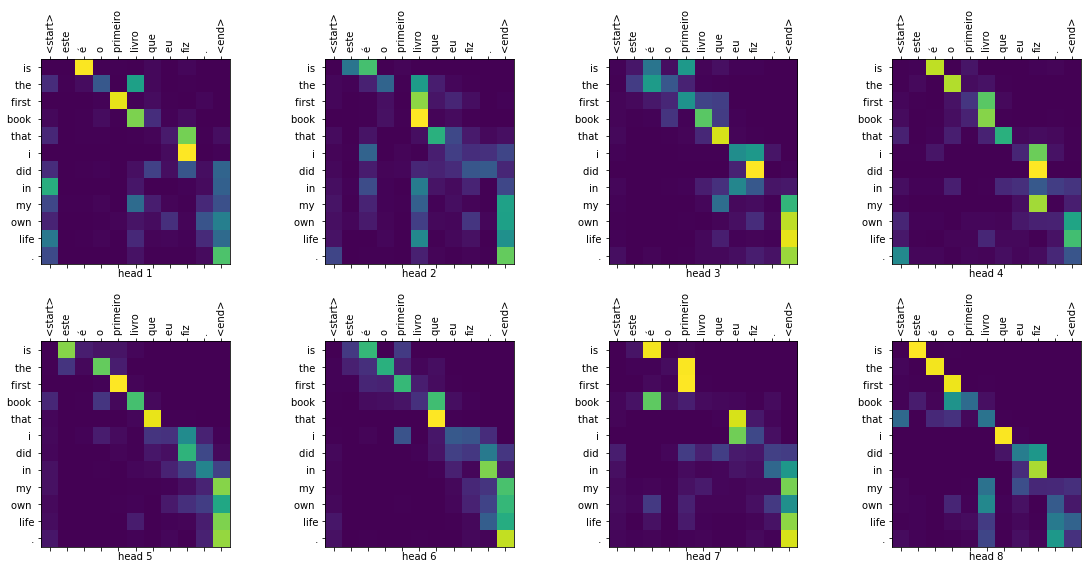

In [ ]:
translate("este é o primeiro livro que eu fiz.", plot='decoder_layer4_block2')
print ("Real translation: this is the first book i've ever done.")